# Chapter 01 - Introduction

## The Philosophy of Bayesian Inferance

In [1]:
# Typical imports
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
# I find toolz a very useful package
import toolz

In [3]:
# Incorporate the custom `matplotlib` styles
import json
from cycler import cycler

# noinspection SpellCheckingInspection
s = json.load(open('./styles/bmh_matplotlibrc.json'))
s['axes.prop_cycle'] = cycler('color', s['axes.prop_cycle']['color'])
matplotlib.rcParams.update(s)

In [4]:
# I don't quite understand why changing this setting increases the size of plots so much, but the settings above
# seem to have no affect.
plt.rcParams['figure.dpi'] = 300

### Our Bayesian Framework

Bayesian inference has three general phases:

- We have *prior* probabilities about our beliefs based on previous information. For example, our belief about the
  presence of bugs in our code.
- We observe evidence (data). Continuing our example, we observe that our code passes $X$ tests.
- We update our prior beliefs using this evidence to determine the *posterior* probabilities about our beliefs.
  Again, our observation of $X$ passing tests increases our belief that the code is bug free.

Notice that our beliefs are not changed _per se_; however, our confidence in those beliefs has changed because we
have observed additional evidence. Also notice that the observed evidence may increase or *decrease* the
plausibility of those beliefs.

Finally, take note that no amount of evidence can (rationally) produce absolute truth; evidence only increases /
decreases the plausibility of our beliefs. Finally, no (finite) number of passing tests can result in a posterior
probability of 1 (certitude), but increasing the number of (well-written) tests can get us, in theory, as close as
one might like.

We begin with a mandatory coin flipping example. Our prior belief is that we have no idea of the fairness of a coin.
We represent this belief by a uniform distribution of probabilities from 0 to 1; that is, a $beta$ distribution
with parameters $a = 1$ and $b = 1$.

Our observations are a sequence of Bernoulli trials of an actual fair coin. (We *do not know* the coin is fair in
"real life."

Mathematically, the $beta$ distribution and a sequence of Bernoulli trials are a _conjugate priors_. This term
means that a $beta$ distribution updated by a sequence of Bernoulli trials produces another $beta$ distribution
with different (updated) parameters $a$ and $b$.

The code below performs these updates and plots the posteriors for an increasing number of trials (an increasing
amount of evidence or data). Note that the updated distributions never produce a single, exact value for the
probability of tossing heads. But, as the number of trials increases, the peak of the posterior probability
distribution becomes narrower and narrower.

In [5]:
# Use a beta distribution for the prior
dist = stats.beta
# Sampled 100 times between 0 and 1
x = np.linspace(0, 1, 100)

# And a Bernoulli likelihood with probability 0.5 and an increasing number of trials
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])

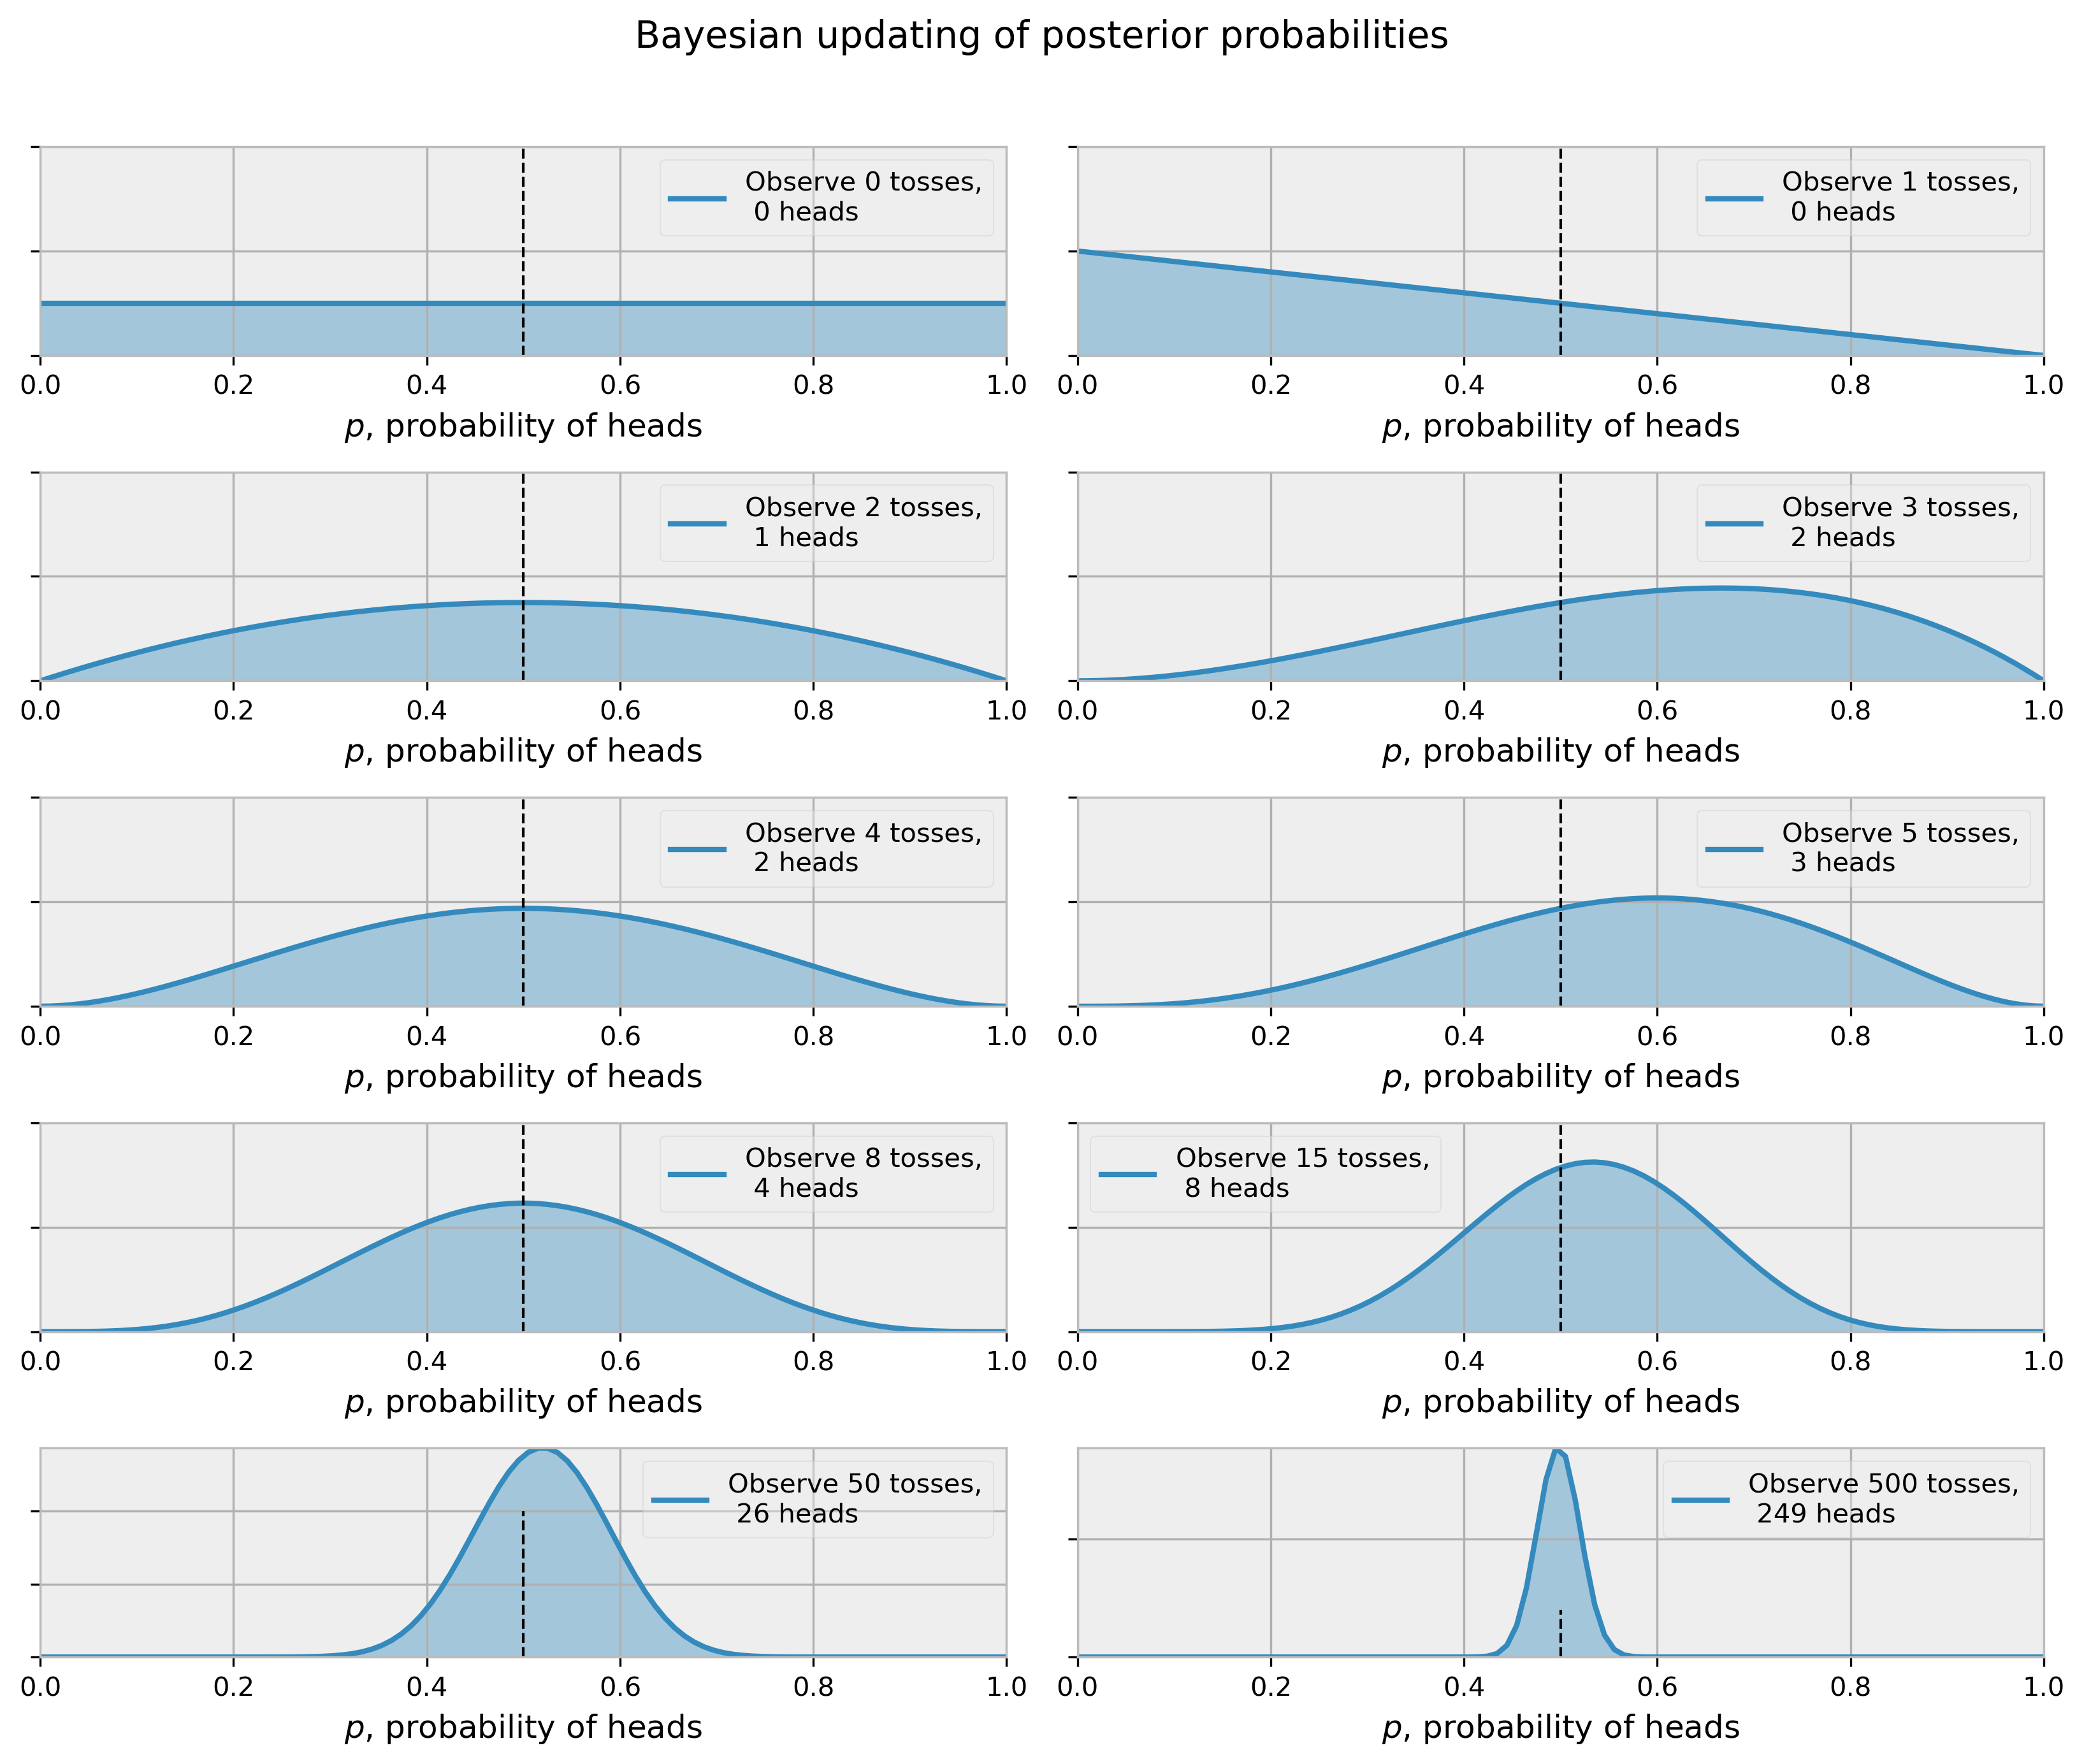

In [6]:
row_count = len(n_trials) // 2
col_count = 2
fig, axes = plt.subplots(row_count, col_count, figsize=(11, 9))
for i, N in enumerate(n_trials):
    # A set of axes for each item in `n_trials` organized as `len(n_triels) // 2` rows by two columns
    ax = axes[i // 2][i % 2]

    # Label the x-axis
    ax.set_xlabel('$p$, probability of heads')
    # With ticks but no labels on the y-axis
    ax.set_yticklabels([])

    # The number of successes (coin flips of heads) in `N` tosses
    heads = data[:N].sum()

    # The posterior distribution given `heads` successes in `N` trials beginning from a uniform prior
    y = dist.pdf(x, 1 + heads, 1 + N - heads)

    # Plot the posterior
    ax.plot(x, y, label=f'Observe {N} tosses,\n {heads} heads')
    ax.fill_between(x, 0, y, color='#348abd', alpha=0.4)
    ax.vlines(0.5, 0, 4, color='k', linestyles='--', lw=1)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.4)
    ax.autoscale(tight=True)

# Add an overall title to all the plots
plt.suptitle('Bayesian updating of posterior probabilities', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

This plot communicates the key idea, additional data decreases the "width" of the posterior distribution;
however, the maximum data of three of the plots are cut off. I tried changing `y_lim` however, this change
had no effect with the other settings. :(

#### Example: Bug, or just sweet, unintended feature

Let's use Bayes' Theorem to determine if our code has any bugs.

Let $A$ denote the "event" (or statement or premise) that *our code has no bugs*. Then $P(A)$ is our belief of
this premise. We do not know this value; we designate it as the value $p$; that is, $P(A) = p$.

We are interested in a different belief: $P(A \mid X)$; that is, the probability that our code has no bugs
given that our code passes a number of tests (the premise, $X$). Using Bayes' Theorem, we can write:

$$
P(A \mid X) = \frac{P(A) P(X \mid A)}{P(X)}
$$

We know that $P(A) = p$ and $P(X \mid A)$ is the probability that our tests pass given that our code has no bugs;
by definition, $P(X \mid A) \equiv 1$.

The value $P(X)$ is tricky; it is the probability that our tests pass whether our code has bugs or not. This
quantity is sometimes called the _total probability_. We can calculate this probability as follows:

$$
P(X) = P(X \mid A)P(A) + P(X \mid \sim A)P(\sim A)
$$

Substituting our values into Bayes' Theorem, we have

$$
P(X \mid A) = \frac{p}{p + P(X \mid \sim A)(1 - p)
$$

The expression $P(X \mid \sim A)$ is the probability that our code passes all tests given that our code *has* bugs.
We'll be conservative and assign this probability the value 0.5. We substitute and get:

$$
P(X \mid A) = \frac{p}{p + 0.5(1-p)}
$$

Eliminating the fraction in the denominator yields the expression

$$
P(X \mid A) = \frac{2p}{2p + (1 - p)} = \frac{2p}{1 + p}
$$

This expression calculates our *posterior probability*; that is the probability that our code has no bugs given
that it passes all our tests.

Let's plot the posterior probability as a function of $p$.

In [7]:
p = np.linspace(0, 1, 50)
posterior =  (2 * p) / (1 + p)

Further, since I'm an experienced programmer, the likelihood that my code has no bugs is rather low; for example, 0.2.

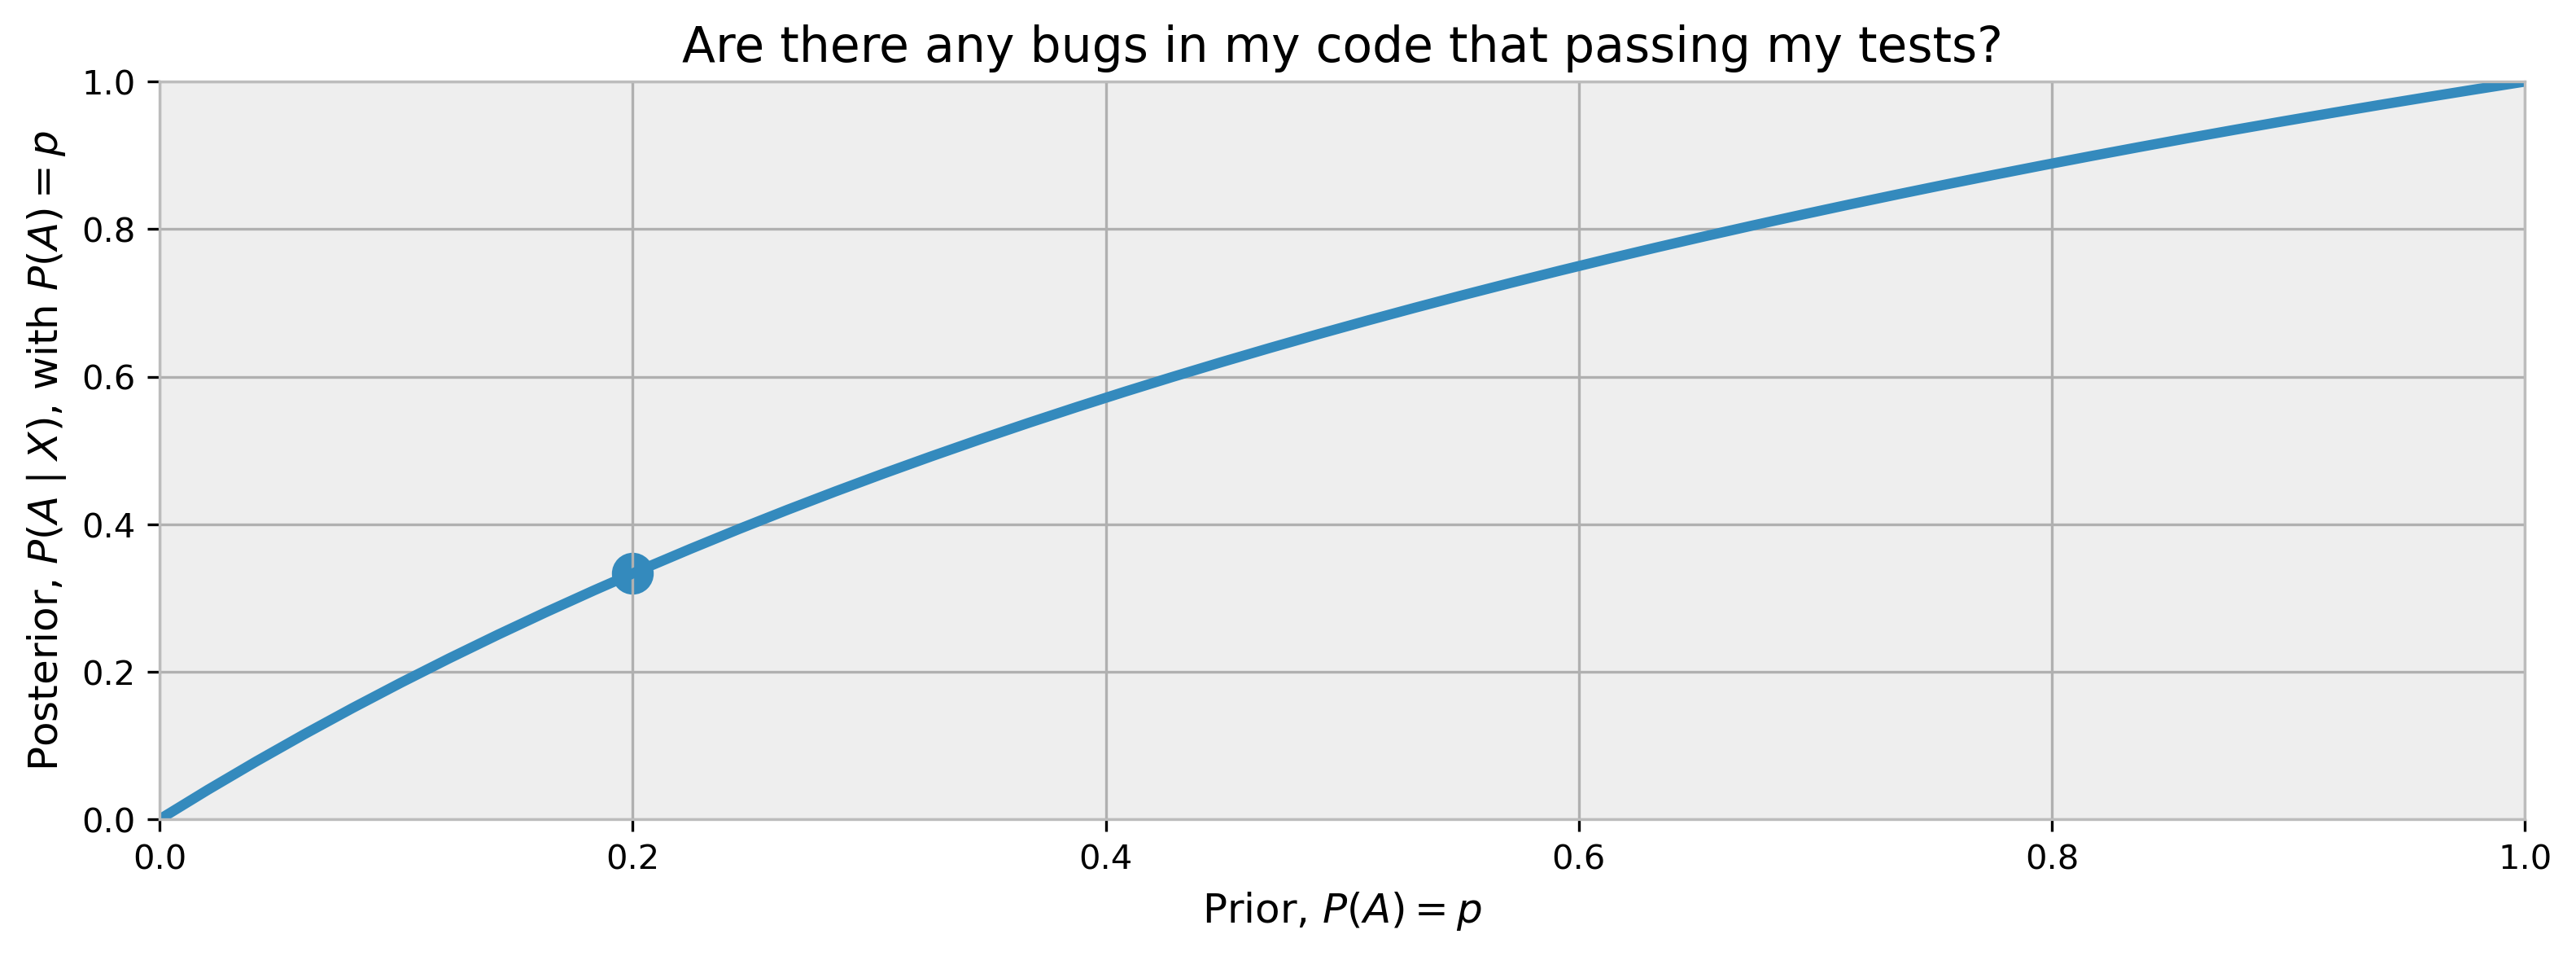

In [8]:
plt.figure(figsize=(12.5, 4))
plt.plot(p, posterior, color='#348abd', lw=3)
plt.scatter(0.2, (2 * 0.2) / (1 + 0.2), color='#348abd', s=140)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Prior, $P(A) = p$')
plt.ylabel('Posterior, $P(A \mid X)$, with $P(A) = p$')
plt.title('Are there any bugs in my code that passing my tests?')
plt.show()

Looking at this curve, we see that the "biggest bang for the buck" occurs for low values of $p$; in other words,
as we write better code, it becomes harder and harder to improve the code using tests.

We assumed that the probability of our code passing all the tests given that it had bugs was 0.5; however, this is
an assumption. Let's plot the posteriors for different values of this expression.

In [9]:
def calculate_posterior(prior, test_effectiveness):
    return prior / (prior + test_effectiveness* (1 - prior))

In [10]:
p = np.linspace(0, 1, 50)
for effectiveness in [0.2, 0.5, 0.8]:
    posterior = calculate_posterior(p, effectiveness)